# Final Project Assigment
---

- For this project, we're going to do an analysis of how consumers talk about three competing brands: Nike, Adidas, and Lululemon.

- Do a network analysis of the tweets that are created that mention those brands. The goal for this project is to better understand the chatter around each brand, what makes each brand unique, and what makes each brand different. We also will use network analysis to identify users that are most central to our brand and ones that are hyper interested in our product category in general, here athletic wear.

---
### **Step 1:** Data Preparation

- Download and Load the Data:
Download and parse the .jsonl file containing the tweet data.
- Action:
Use the previously mentioned function to load the data and extract relevant fields (user ID, mentions, text, and follower count).

### We are only going to use twitter users with **MORE THAN 200k Followers!**
---


In [ ]:
!pip install pyvis

In [ ]:
import json
import gzip
import datetime
import nltk
from collections import Counter
from google.colab import drive

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Mount the Google Drive
drive.mount('/content/drive')

DATA_FILE = "drive/MyDrive/nikelululemonadidas_tweets.jsonl.gz"

def match_tweet(tweet, start_date=None, end_date=None):
    """Return the boolean value of whether this tweet object matches
    the specified parameters (only start_date and end_date)."""

    # Parse the tweet's created_at field into a datetime.date object
    try:
        tweet_date = datetime.datetime.strptime(tweet["created_at"], "%a %b %d %H:%M:%S +0000 %Y").date()
        #print(f"Parsed Tweet Date: {tweet_date}")
    except Exception as e:
        #print(f"Error parsing date for tweet: {tweet.get('created_at')}, error: {e}")
        return False

    # Match by start_date if provided
    if start_date and tweet_date < start_date:
        return False  # The tweet is older than the start date

    # Match by end_date if provided
    if end_date and tweet_date > end_date:
        return False  # The tweet is newer than the end date


    return True

# Filter and parse tweets based on date range (no country code filtering)
def filter_and_parse_tweets(data_file, start_date=None, end_date=None):
    tweets_data = []
    users = {}
    with gzip.open(data_file, 'rt', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if i % 10000 == 0:
                print(f"{i} tweets processed")

            tweet = json.loads(line)

            # Check if the tweet matches the date filtering criteria
            if match_tweet(tweet, start_date=start_date, end_date=end_date):
                user = tweet["user"]
                user_id = user["id"]
                screen_name = user["screen_name"]  # Get the screen name
                tweet_text = tweet.get("full_text", tweet.get("text", ""))
                followers_count = user["followers_count"]

                # Store user data (including screen_name)
                if user_id not in users:
                    users[user_id] = {
                        "id": user_id,
                        "screen_name": screen_name,                             # Add screen_name to the user data
                        "tweet_count": 0,
                        "followers_count": followers_count,
                        "mentions": []                                         # Which brands the user has mentioned
                    }
                users[user_id]["tweet_count"] += 1

                # Store the tweet data for semantic analysis and later steps
                tweets_data.append({
                    "user_id": user_id,
                    "screen_name": screen_name,                                 # Include screen_name in the tweet data
                    "followers_count": followers_count,
                    "text": tweet_text,
                    "date": tweet["created_at"],
                    "mentions": [mention["screen_name"] for mention in tweet["entities"]["user_mentions"]]
                })

    return tweets_data, users



# Set the correct start and end dates based on the data
start_date = datetime.date(2021, 10, 1)
end_date = datetime.date(2022, 1, 1)                                            # Matches the max date found in the data

# Filter tweets (no country code filtering, only by date)
tweets_data, users = filter_and_parse_tweets(DATA_FILE, start_date=start_date, end_date=end_date)

print(f"Total tweets processed: {len(tweets_data)}")
print(f"Total users processed: {len(users)}")

# Filter users based on follower count and tweet count (influentials)
included_user_ids = []
min_tweet_count = 2                                                             # User must have tweeted about it at least twice.
min_followers_count = 300000                                                    # User Must have 300K + followers to be included.

for user_id, user in users.items():
    if user["tweet_count"] >= min_tweet_count and user["followers_count"] >= min_followers_count:
        included_user_ids.append(user_id)

print(f"Length of included_user_ids: {len(included_user_ids)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
Total tweets processed: 175078
Total users processed: 104772
Length of included_user_ids: 94


In [ ]:
import nltk
import string

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Tokenization function
def tokenize(text, lowercase=True, tweet=False):
    """Tokenize the text. By default, also normalizes text to lowercase.
    Optionally uses the Tweet Tokenizer.
    """
    if lowercase:
        text = text.lower()
    if tweet:
        return nltk.TweetTokenizer().tokenize(text)
    else:
        return nltk.word_tokenize(text)

# Preprocessing functions
def remove_stopwords(tokens, stopwords=None):
    """Remove stopwords from tokens."""
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [token for token in tokens if token not in stopwords]

def remove_links(tokens):
    """Remove links from tokens."""
    return [t for t in tokens if not (t.startswith("http://") or t.startswith("https://"))]

def remove_punctuation_and_short_words(tokens, min_word_length=3, strip_mentions=False, strip_hashtags=False):
    """
    Remove punctuation from tokens and words shorter than the given length.
    """
    tokens = [t for t in tokens if t not in string.punctuation and len(t) >= min_word_length]
    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]
    return tokens

def lemmatize(tokens):
    """Lemmatize tokens."""
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_custom_unwanted_words(tokens, unwanted=None):
    """Remove custom unwanted words from tokens."""
    if unwanted is None:
        unwanted = {"rt", "...", "'", '"', "`"}  # Set of unwanted tokens
    return [token for token in tokens if token not in unwanted]

# Preprocess the tweet text
def preprocess_tweet_text(tweets, stopwords=nltk.corpus.stopwords.words("english"), min_word_length=3):
    all_tokens = set()
    for tweet in tweets:
        text = tweet["text"]
        tokens = tokenize(text, lowercase=True, tweet=True)
        tokens = remove_stopwords(tokens, stopwords=stopwords)
        tokens = remove_links(tokens)
        tokens = remove_punctuation_and_short_words(tokens, min_word_length=min_word_length, strip_mentions=True, strip_hashtags=True)
        tokens = lemmatize(tokens)
        tokens = remove_custom_unwanted_words(tokens)  # Remove custom unwanted words
        all_tokens.update(tokens)  # Add the tokens to the set of unique tokens
    return all_tokens

# Preprocess and extract unique tokens
unique_tokens = preprocess_tweet_text(tweets_data)
print(f"Unique tokens in the dataset: {len(unique_tokens)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Unique tokens in the dataset: 85281


In [ ]:
unique_tokens = preprocess_tweet_text(tweets_data)
print(f"Unique tokens in the dataset: {len(unique_tokens)}")

Unique tokens in the dataset: 85281


# Question 1: **Who are the Most Central Users?**

### **Step 2:** Twitter Mention Graph (Who are the Most Central Users?)

- Build a Directed Mention Graph:
Create a directed graph where nodes represent Twitter users and edges represent mentions.
- Filter out non-relevant users or those with low follower counts.
Question: Who are the most central users?

- Calculate degree centrality and identify the top 10 most central users for each brand. Central users are those who mention a brand the most or get mentioned by others frequently.
- Action:
Use networkx.degree_centrality() to identify the most central users in the graph.
Separate the central users for each brand (@nike, @adidas, @lululemon).

---

In [ ]:
import networkx as nx
from collections import defaultdict

# Build a directed graph for Twitter mentions of brands
def build_brand_mentions_graph(tweets_data, included_user_ids):
    G = nx.DiGraph()  # Create a directed graph
    brands = ["nike", "adidas", "lululemon"]                                     # List of brands to track
    brand_mentions = defaultdict(set)                                             # To track users mentioning each brand

    for tweet in tweets_data:
        sender_id = tweet["user_id"]
        tweet_text = tweet.get("full_text", tweet.get("text", "")).lower()

        # Only include tweets from users with enough followers (influentials)
        if sender_id in included_user_ids:
            G.add_node(sender_id)                                               # Add the user as a node

            # Add edges from users to the brands they mention
            if "nike" in tweet_text:
                G.add_edge(sender_id, "nike")               # User mentions Nike
                brand_mentions["nike"].add(sender_id)
            if "adidas" in tweet_text:
                G.add_edge(sender_id, "adidas")             # User mentions Adidas
                brand_mentions["adidas"].add(sender_id)
            if "lululemon" in tweet_text:
                G.add_edge(sender_id, "lululemon")          # User mentions Lululemon
                brand_mentions["lululemon"].add(sender_id)

    return G, brand_mentions

# Build the brand mention graph
mention_graph, brand_mentions = build_brand_mentions_graph(tweets_data, included_user_ids)

# Check if we captured users mentioning brands
print(f"Users who mentioned Nike: {len(brand_mentions['nike'])}")
print(f"Users who mentioned Adidas: {len(brand_mentions['adidas'])}")
print(f"Users who mentioned Lululemon: {len(brand_mentions['lululemon'])}")

# Calculate degree centrality for the entire graph (mentioning brands)
degree_centrality = nx.degree_centrality(mention_graph)

# Function to find the top 10 most central users for each brand
def top_central_users_for_brand(brand, brand_mentions, degree_centrality, top_n=10):
    central_users = []
    for user in brand_mentions[brand]:
        if user in degree_centrality:
            central_users.append((user, degree_centrality[user]))
    # Sort by centrality and take the top N users
    central_users = sorted(central_users, key=lambda x: x[1], reverse=True)[:top_n]
    return central_users

# Get the top 10 central users for each brand
top_nike_users = top_central_users_for_brand("nike", brand_mentions, degree_centrality)
top_adidas_users = top_central_users_for_brand("adidas", brand_mentions, degree_centrality)
top_lululemon_users = top_central_users_for_brand("lululemon", brand_mentions, degree_centrality)

# Print the top 10 most central users for each brand
print("\nTop 10 central users for Nike:")
for user, centrality in top_nike_users:
    print(f"User ID: {user}, Centrality: {centrality}")

print("\nTop 10 central users for Adidas:")
for user, centrality in top_adidas_users:
    print(f"User ID: {user}, Centrality: {centrality}")

print("\nTop 10 central users for Lululemon:")
for user, centrality in top_lululemon_users:
    print(f"User ID: {user}, Centrality: {centrality}")


Users who mentioned Nike: 61
Users who mentioned Adidas: 43
Users who mentioned Lululemon: 13

Top 10 central users for Nike:
User ID: 19784831, Centrality: 0.03125
User ID: 574186881, Centrality: 0.020833333333333332
User ID: 35203319, Centrality: 0.020833333333333332
User ID: 11319582, Centrality: 0.020833333333333332
User ID: 2207129125, Centrality: 0.020833333333333332
User ID: 1666038950, Centrality: 0.020833333333333332
User ID: 26012202, Centrality: 0.020833333333333332
User ID: 15537451, Centrality: 0.020833333333333332
User ID: 7846, Centrality: 0.020833333333333332
User ID: 3224616765, Centrality: 0.020833333333333332

Top 10 central users for Adidas:
User ID: 19784831, Centrality: 0.03125
User ID: 574186881, Centrality: 0.020833333333333332
User ID: 30205586, Centrality: 0.020833333333333332
User ID: 11319582, Centrality: 0.020833333333333332
User ID: 2207129125, Centrality: 0.020833333333333332
User ID: 1666038950, Centrality: 0.020833333333333332
User ID: 26012202, Central

In [ ]:
import networkx as nx
from collections import defaultdict

# Build a directed graph for Twitter mentions of brands
def build_brand_mentions_graph(tweets_data, included_user_ids):
    G = nx.DiGraph()  # Create a directed graph
    brands = ["nike", "adidas", "lululemon"]  # List of brands to track
    brand_mentions = defaultdict(set)  # To track users mentioning each brand
    user_id_to_name = {}  # Dictionary to map user_id to screen_name

    for tweet in tweets_data:
        sender_id = tweet["user_id"]
        screen_name = tweet["screen_name"]  # Get the user's screen_name
        tweet_text = tweet.get("full_text", tweet.get("text", "")).lower()

        # Only include tweets from users with enough followers (influentials)
        if sender_id in included_user_ids:
            G.add_node(sender_id)  # Add the user as a node

            # Map user_id to screen_name
            user_id_to_name[sender_id] = screen_name

            # Add edges from users to the brands they mention
            if "nike" in tweet_text:
                G.add_edge(sender_id, "nike")  # User mentions Nike
                brand_mentions["nike"].add(sender_id)
            if "adidas" in tweet_text:
                G.add_edge(sender_id, "adidas")  # User mentions Adidas
                brand_mentions["adidas"].add(sender_id)
            if "lululemon" in tweet_text:
                G.add_edge(sender_id, "lululemon")  # User mentions Lululemon
                brand_mentions["lululemon"].add(sender_id)

    return G, brand_mentions, user_id_to_name

# Build the brand mention graph
mention_graph, brand_mentions, user_id_to_name = build_brand_mentions_graph(tweets_data, included_user_ids)

# Check if we captured users mentioning brands
print(f"Users who mentioned Nike: {len(brand_mentions['nike'])}")
print(f"Users who mentioned Adidas: {len(brand_mentions['adidas'])}")
print(f"Users who mentioned Lululemon: {len(brand_mentions['lululemon'])}")

# Calculate degree centrality for the entire graph (mentioning brands)
degree_centrality = nx.degree_centrality(mention_graph)

# Function to find the top 10 most central users for each brand
def top_central_users_for_brand(brand, brand_mentions, degree_centrality, user_id_to_name, top_n=10):
    central_users = []
    for user in brand_mentions[brand]:
        if user in degree_centrality:
            central_users.append((user, degree_centrality[user]))
    # Sort by centrality and take the top N users
    central_users = sorted(central_users, key=lambda x: x[1], reverse=True)[:top_n]

    # Include screen_name in the output
    central_users_with_names = [(user, user_id_to_name.get(user, "Unknown"), centrality) for user, centrality in central_users]
    return central_users_with_names

# Get the top 10 central users for each brand
top_nike_users = top_central_users_for_brand("nike", brand_mentions, degree_centrality, user_id_to_name)
top_adidas_users = top_central_users_for_brand("adidas", brand_mentions, degree_centrality, user_id_to_name)
top_lululemon_users = top_central_users_for_brand("lululemon", brand_mentions, degree_centrality, user_id_to_name)

# Print the top 10 most central users for each brand, including screen names
print("\nTop 10 central users for Nike:")
for user, screen_name, centrality in top_nike_users:
    print(f"User ID: {user}, Screen Name: {screen_name}, Centrality: {centrality}")

print("\nTop 10 central users for Adidas:")
for user, screen_name, centrality in top_adidas_users:
    print(f"User ID: {user}, Screen Name: {screen_name}, Centrality: {centrality}")

print("\nTop 10 central users for Lululemon:")
for user, screen_name, centrality in top_lululemon_users:
    print(f"User ID: {user}, Screen Name: {screen_name}, Centrality: {centrality}")

Users who mentioned Nike: 61
Users who mentioned Adidas: 43
Users who mentioned Lululemon: 13

Top 10 central users for Nike:
User ID: 19784831, Screen Name: wwd, Centrality: 0.03125
User ID: 574186881, Screen Name: snkr_twitr, Centrality: 0.020833333333333332
User ID: 35203319, Screen Name: EvanKirstel, Centrality: 0.020833333333333332
User ID: 11319582, Screen Name: highsnobiety, Centrality: 0.020833333333333332
User ID: 2207129125, Screen Name: Cointelegraph, Centrality: 0.020833333333333332
User ID: 1666038950, Screen Name: BoredElonMusk, Centrality: 0.020833333333333332
User ID: 26012202, Screen Name: dezeen, Centrality: 0.020833333333333332
User ID: 15537451, Screen Name: SLAMonline, Centrality: 0.020833333333333332
User ID: 7846, Screen Name: ijustine, Centrality: 0.020833333333333332
User ID: 3224616765, Screen Name: TechInsider, Centrality: 0.020833333333333332

Top 10 central users for Adidas:
User ID: 19784831, Screen Name: wwd, Centrality: 0.03125
User ID: 574186881, Screen

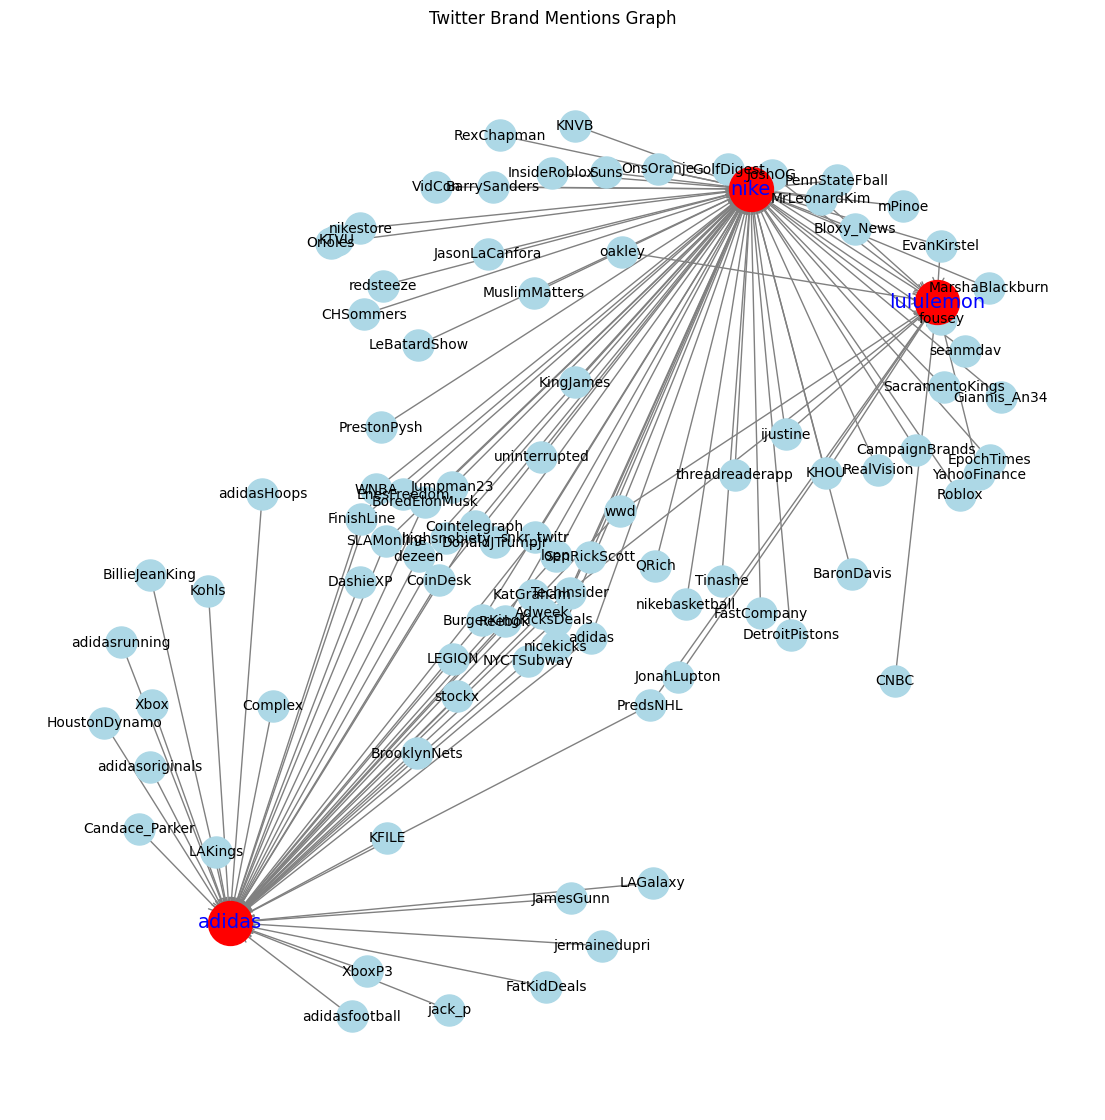

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize the brand mention graph with highlighted brand nodes and better separation
def visualize_brand_mentions_graph(mention_graph, user_id_to_name, brands, figsize=(14, 14)):
    plt.figure(figsize=figsize)

    # Generate positions for each node with more separation
    pos = nx.spring_layout(mention_graph, k=0.5, seed=42)

    # Draw all nodes and edges
    nx.draw_networkx_nodes(mention_graph, pos, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(mention_graph, pos, arrowstyle='->', arrowsize=20, edge_color="gray")

    # Highlight brand nodes by increasing their size and changing color
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=brands, node_size=1000, node_color="red")  # Change to 'red'

    # Create labels for users and brands
    labels = {user_id: user_id_to_name.get(user_id, "" ) for user_id in mention_graph.nodes}

    # Draw labels with increased font size for better readability
    nx.draw_networkx_labels(mention_graph, pos, labels, font_size=10, font_color="black")

    # Draw brand labels with larger font size and different font color
    brand_labels = {brand: brand for brand in brands}
    nx.draw_networkx_labels(mention_graph, pos, labels=brand_labels, font_size=14, font_color="blue")  # Change font color to 'yellow'

    plt.title("Twitter Brand Mentions Graph")
    plt.axis("off")  # Turn off the axis
    plt.show()

# List of brand names
brands = ["nike", "adidas", "lululemon"]

# Visualize the mention graph with better node separation and custom brand node color
visualize_brand_mentions_graph(mention_graph, user_id_to_name, brands)

---
**Overlap Between Brands:**
### Summary:

- Nike and Adidas are highly interconnected with each other and share a large audience on Twitter.
- Lululemon has a more distinct and separate cluster of users, suggesting it may appeal to a different demographic or community.
- There are several influential users (e.g., KingJames, Cointelegraph) that engage with multiple brands, acting as important nodes in the network.

---


### **Step 3**: Identifying Bridgers (Who are the Most Important Bridgers?)

- Identify Users Who Mention Multiple Brands:
A bridger is a user who mentions more than one brand (Nike, Adidas, Lululemon).
Question: Who are the most important bridgers?

- Identify users who mention multiple brands and their centrality in the graph.
These users can be highly valuable for marketing purposes due to their engagement with multiple brands.
Action:

- Write a function that identifies users who mention two or more brands and calculates their centrality.
---



Top Bridgers (mentioning multiple brands):
User ID: 19784831, Centrality: 0.03125, Mentioned Brands: ['Nike', 'Adidas', 'Lululemon']
User ID: 11319582, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 2207129125, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 26012202, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 15537451, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 3224616765, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 22175551, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 21915474, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']
User ID: 15791186, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Lululemon']
User ID: 1333467482, Centrality: 0.020833333333333332, Mentioned Brands: ['Nike', 'Adidas']


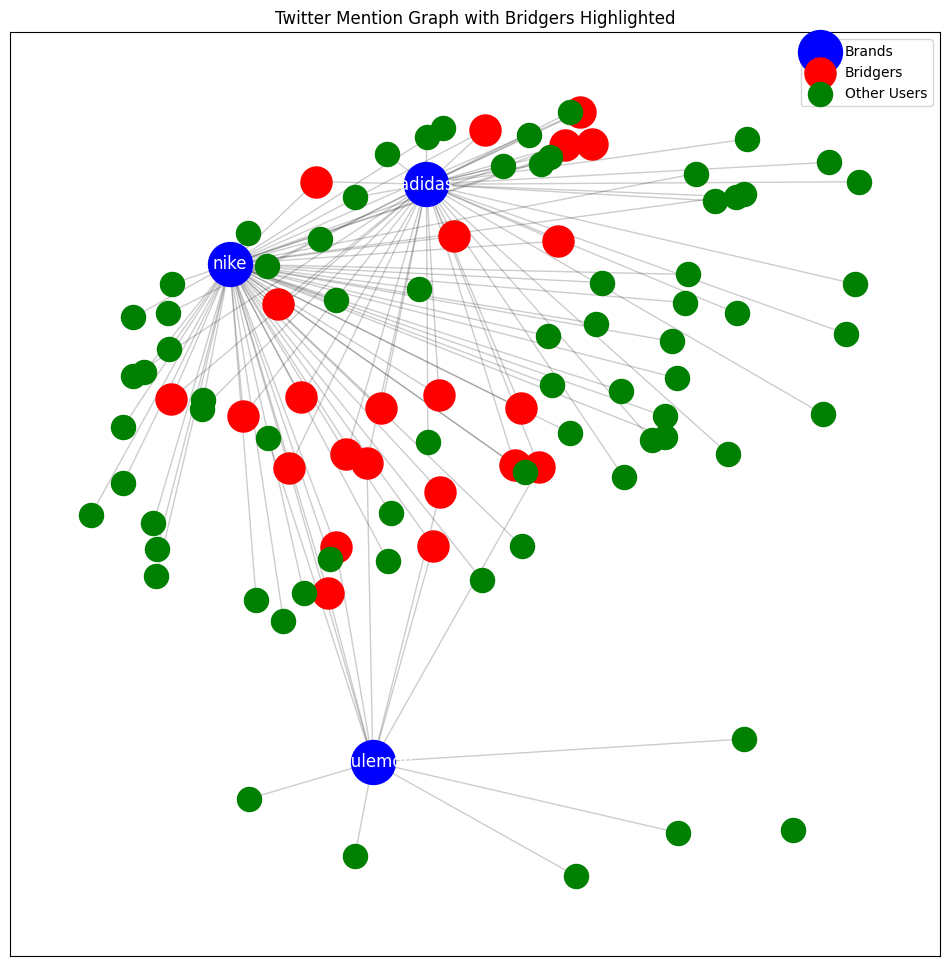

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to identify bridgers (users who mention two or more brands)
def identify_bridgers(brand_mentions):
    bridgers = {}

    # Loop through all users who mention any of the brands
    for user_id in set(brand_mentions["nike"]).union(brand_mentions["adidas"], brand_mentions["lululemon"]):
        mentioned_brands = []
        if user_id in brand_mentions["nike"]:
            mentioned_brands.append("Nike")
        if user_id in brand_mentions["adidas"]:
            mentioned_brands.append("Adidas")
        if user_id in brand_mentions["lululemon"]:
            mentioned_brands.append("Lululemon")

        # If the user mentioned two or more brands, they're a bridger
        if len(mentioned_brands) > 1:
            bridgers[user_id] = mentioned_brands  # Store the brands they mentioned

    return bridgers

# Identify bridgers
bridgers = identify_bridgers(brand_mentions)

# Calculate centrality for bridgers
def centrality_for_bridgers(bridgers, degree_centrality):
    bridger_centrality = []

    for user_id in bridgers:
        if user_id in degree_centrality:
            bridger_centrality.append((user_id, degree_centrality[user_id], bridgers[user_id]))

    # Sort bridgers by centrality
    bridger_centrality = sorted(bridger_centrality, key=lambda x: x[1], reverse=True)
    return bridger_centrality

# Get centrality for bridgers
bridger_centrality = centrality_for_bridgers(bridgers, degree_centrality)

# Print the most important bridgers
print("\nTop Bridgers (mentioning multiple brands):")
for user_id, centrality, mentioned_brands in bridger_centrality[:10]:  # Top 10 bridgers
    print(f"User ID: {user_id}, Centrality: {centrality}, Mentioned Brands: {mentioned_brands}")

# Function to visualize bridgers in the mention graph
def visualize_bridgers(mention_graph, bridgers, brands):
    # Create a layout for the graph
    pos = nx.spring_layout(mention_graph, k=0.5, iterations=50)

    plt.figure(figsize=(12, 12))

    # Draw all nodes and edges in the graph
    nx.draw_networkx_edges(mention_graph, pos, alpha=0.2)

    # Draw nodes for brands (Nike, Adidas, Lululemon)
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=brands, node_color='blue', node_size=1000, label="Brands")

    # Draw nodes for bridgers (users who mention multiple brands)
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=bridgers.keys(), node_color='red', node_size=500, label="Bridgers")

    # Draw remaining users (non-bridgers)
    non_bridgers = set(mention_graph.nodes()) - set(bridgers.keys()) - set(brands)
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=non_bridgers, node_color='green', node_size=300, label="Other Users")

    # Add labels for brands
    nx.draw_networkx_labels(mention_graph, pos, labels={node: node for node in brands}, font_size=12, font_color="white")

    plt.legend(scatterpoints=1)
    plt.title("Twitter Mention Graph with Bridgers Highlighted")
    plt.show()

# Define brands as nodes
brands = ["nike", "adidas", "lululemon"]

# Visualize the graph highlighting bridgers
visualize_bridgers(mention_graph, bridgers, brands)


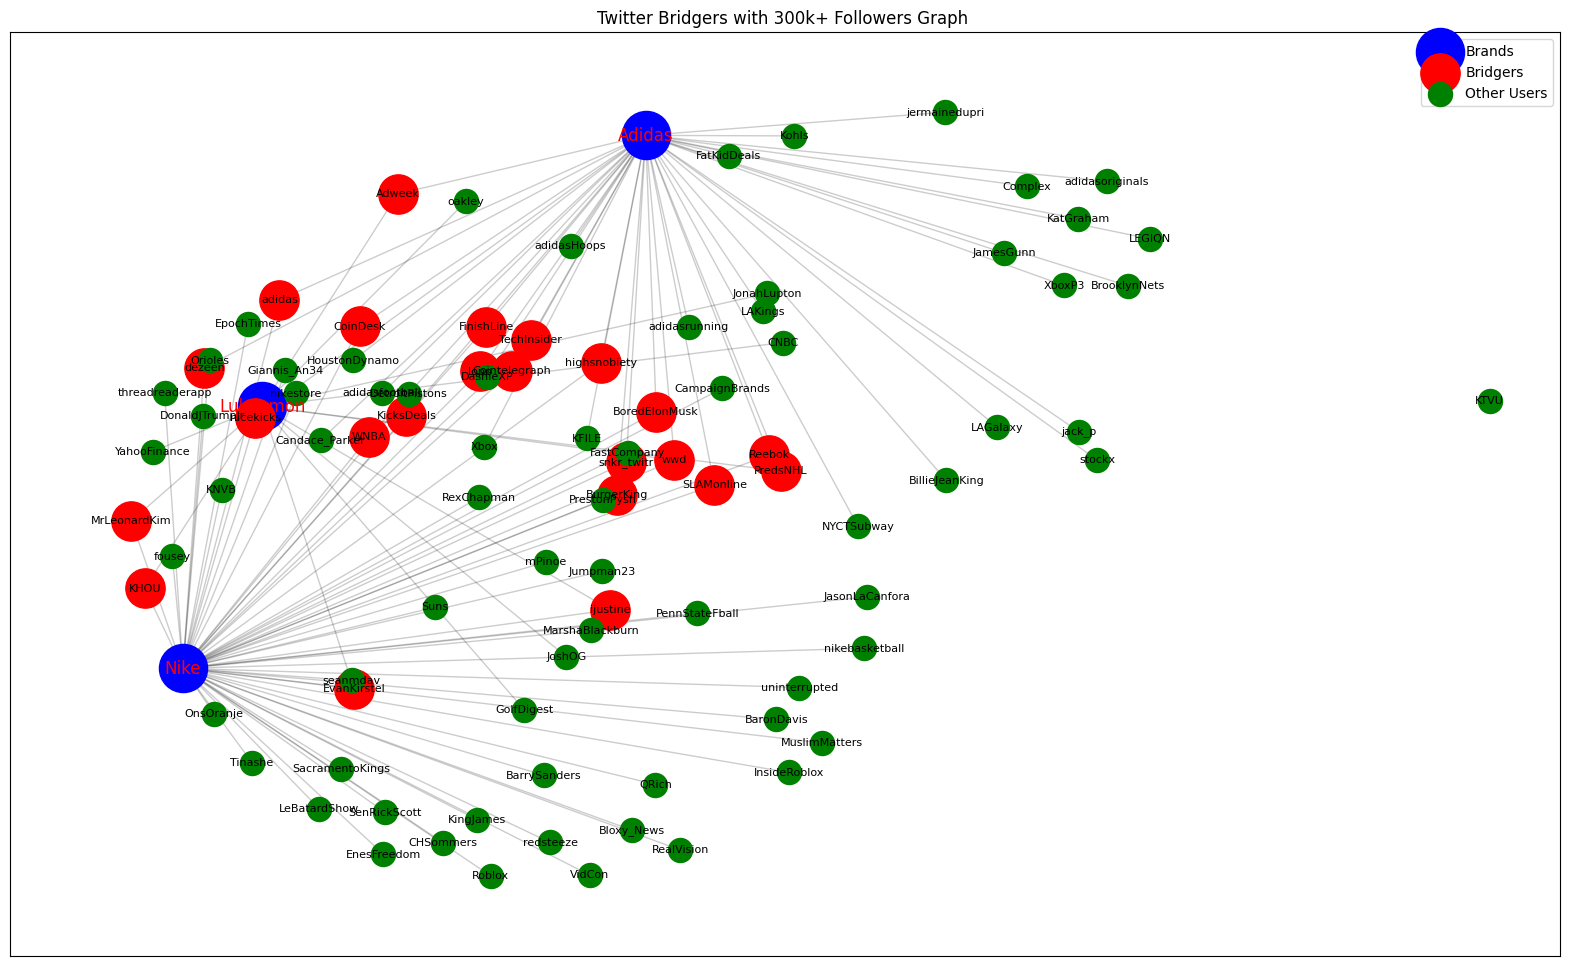

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize the mention graph with all screen names and smaller font size
def visualize_all_screen_names(mention_graph, user_id_to_name, brands, bridgers):
    # Create a layout for the graph
    pos = nx.spring_layout(mention_graph, k=0.5, iterations=50)

    plt.figure(figsize=(20, 12))

    # Draw all edges with default styling
    nx.draw_networkx_edges(mention_graph, pos, alpha=0.2)

    # Draw nodes for brands (Nike, Adidas, Lululemon)
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=brands, node_color='blue', node_size=1200, label="Brands")

    # Draw nodes for bridgers (users who mention multiple brands)
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=bridgers.keys(), node_color='red', node_size=800, label="Bridgers")
    non_bridgers = set(mention_graph.nodes()) - set(bridgers.keys()) - set(brands)
    nx.draw_networkx_nodes(mention_graph, pos, nodelist=non_bridgers, node_color='green', node_size=300, label="Other Users")
    all_labels = {user_id: user_id_to_name.get(user_id, " ") for user_id in mention_graph.nodes}
    brand_labels = {brand: brand.capitalize() for brand in brands}  # Brand-specific labels
    nx.draw_networkx_labels(mention_graph, pos, labels=all_labels, font_size=8, font_color="black")

    # Draw brand labels separately with larger font size and distinct color
    nx.draw_networkx_labels(mention_graph, pos, labels=brand_labels, font_size=12, font_color="red")

    # Add legend and title
    plt.legend(scatterpoints=1)
    plt.title("Twitter Bridgers with 300k+ Followers Graph ")
    plt.show()

# Define brands
brands = ["nike", "adidas", "lululemon"]

# Visualize the graph with all screen names
visualize_all_screen_names(mention_graph, user_id_to_name, brands, bridgers)

### **Step 4:** Semantic Word Clusters

- Build a Semantic Network of Words:
Process the tweet text to extract key words and build a co-occurrence network where nodes represent words, and edges represent co-occurrences within a tweet.
Question: What are the key clusters of words? What clusters does each brand own?

- Identify clusters of words associated with each brand. These clusters will represent different themes or conversations surrounding the brand.
Use community detection algorithms to find clusters.
Action:

- Use word co-occurrence to build a graph and run community detection.
---

In [ ]:
pip install python-louvain

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cooccurrences example: [('nike', 'available'), ('nike', 'sneakerscouts'), ('nike', 'nike'), ('available', 'sneakerscouts'), ('available', 'nike'), ('sneakerscouts', 'nike')]


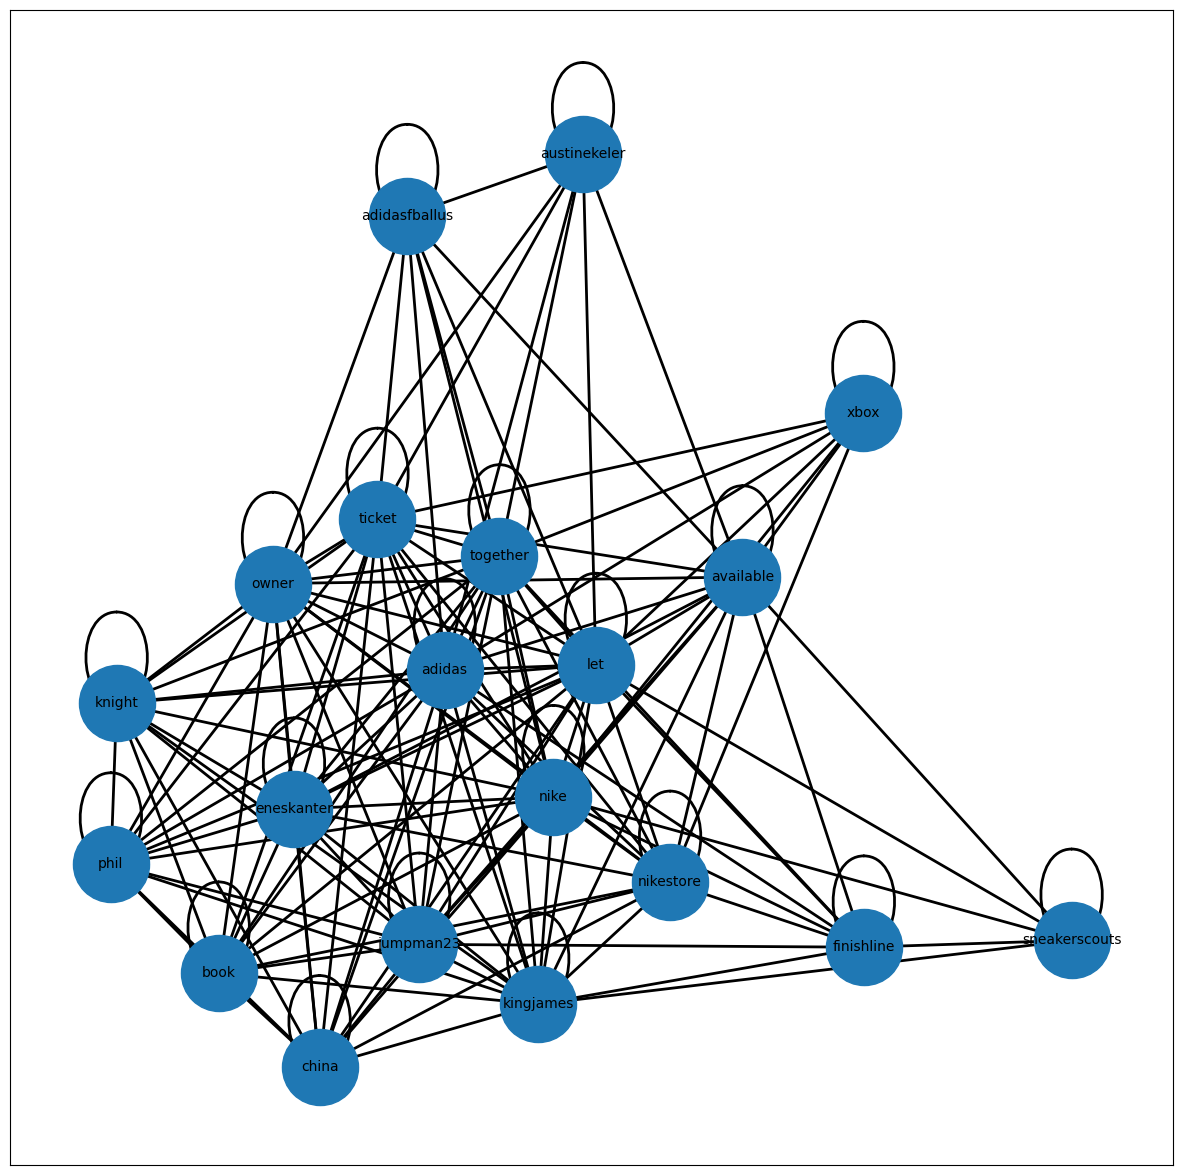

Total tweets processed: 175078
Total users processed: 104772
Included user IDs: 94


In [ ]:
import nltk
import string

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Extend the NLTK stopwords list with "rt"
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add('rt')

# Tokenization and text processing functions
def tokenize(text, lowercase=True, tweet=False):
    if lowercase:
        text = text.lower()
    if tweet:
        return nltk.TweetTokenizer().tokenize(text)
    else:
        return nltk.word_tokenize(text)

def remove_stopwords(tokens, stopwords=None):
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [token for token in tokens if token not in stopwords]

def remove_links(tokens):
    return [t for t in tokens if not t.startswith("http://") and not t.startswith("https://")]

def remove_punctuation_and_short_words(tokens, min_word_length=4, strip_mentions=False, strip_hashtags=False, strict=False):
    """
    Remove punctuation from tokens and words shorter than the given length.
    """
    tokens = [t for t in tokens if t not in string.punctuation and len(t) >= min_word_length]

    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]

    if strict:
        cleaned = []
        for t in tokens:
            cleaned_token = t.translate(str.maketrans('', '', string.punctuation)).strip()
            if len(cleaned_token) >= min_word_length:  # Filter out words shorter than min_word_length after cleaning
                cleaned.append(cleaned_token)
        tokens = [t for t in cleaned if t]

    # Additional filter for specific unwanted tokens
    unwanted = {"...", "'", '"', "`"}
    return [token for token in tokens if token not in unwanted]

def lemmatize(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Word count dictionary for top terms
word_counts = Counter()
for tweet_data in tweets_data:
    text = tweet_data["text"]
    tokens = tokenize(text, tweet=True)
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords)

    # Using the new function to remove punctuation and short words
    tokens = remove_punctuation_and_short_words(tokens, min_word_length=4, strip_mentions=True, strip_hashtags=True, strict=True)

    tokens = lemmatize(tokens)

    for word in tokens:
        word_counts[word] += 1

# Top N terms
N = 20
top_terms = [term for term, _ in word_counts.most_common(N)]

# Build semantic network (this function should remain unchanged)
semantic_graph = build_semantic_network(tweets_data, top_terms)

# Visualize the network
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(semantic_graph, ax=ax, font_color="#000000", font_size=10, node_size=3000, width=2)
plt.show()

print(f"Total tweets processed: {len(tweets_data)}")
print(f"Total users processed: {len(users)}")
print(f"Included user IDs: {len(included_user_ids)}")

Cooccurrences example: [('nike', 'available'), ('nike', 'sneakerscouts'), ('nike', 'nike'), ('available', 'sneakerscouts'), ('available', 'nike'), ('sneakerscouts', 'nike')]


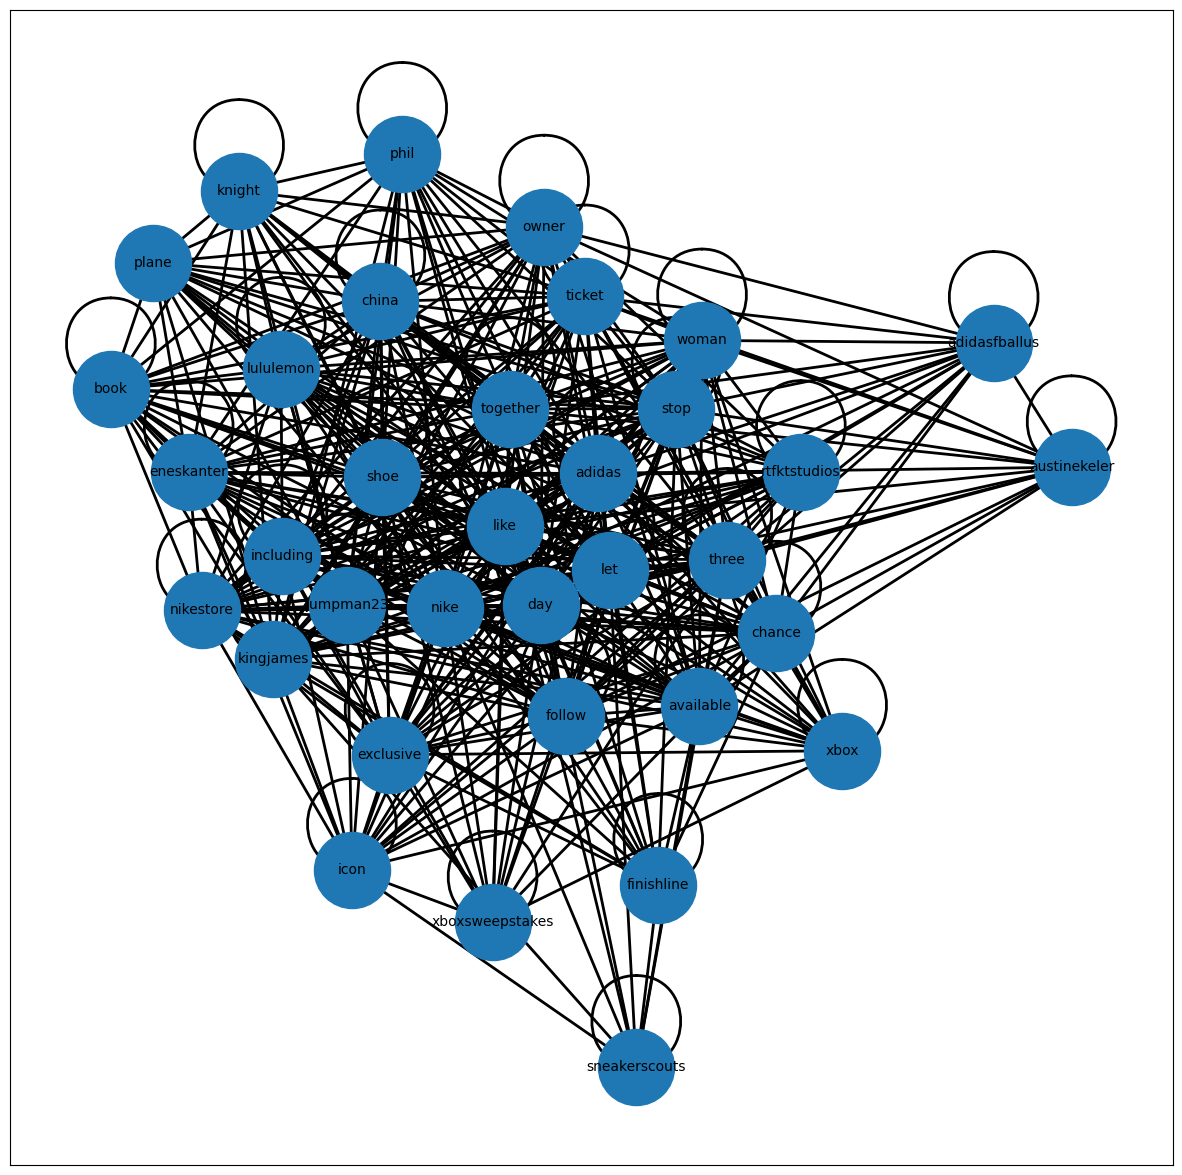

Total tweets processed: 175078
Total users processed: 104772
Included user IDs: 94


In [ ]:
# Top N terms
N = 35
top_terms = [term for term, _ in word_counts.most_common(N)]

# Build semantic network
semantic_graph = build_semantic_network(tweets_data, top_terms)

# Visualize the network
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(semantic_graph, ax=ax, font_color="#000000", font_size=10, node_size=3000, width=2)
plt.show()

print(f"Total tweets processed: {len(tweets_data)}")
print(f"Total users processed: {len(users)}")
print(f"Included user IDs: {len(included_user_ids)}")

### **Step 5:** Brand-Specific Word Ownership (What Word Clusters Does Each Brand Own?)

- Analyze Word Clusters for Each Brand:
For each brand, identify the most important word clusters. These clusters will highlight the themes and attributes that each brand "owns."
Question: What attributes (words or clusters) are uniquely linked to each brand?

- Identify words that are central to each brand and reflect its unique position in the market.
Action:

- Filter the co-occurrence graph by brand mentions to see which clusters are most associated with each brand.
---


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


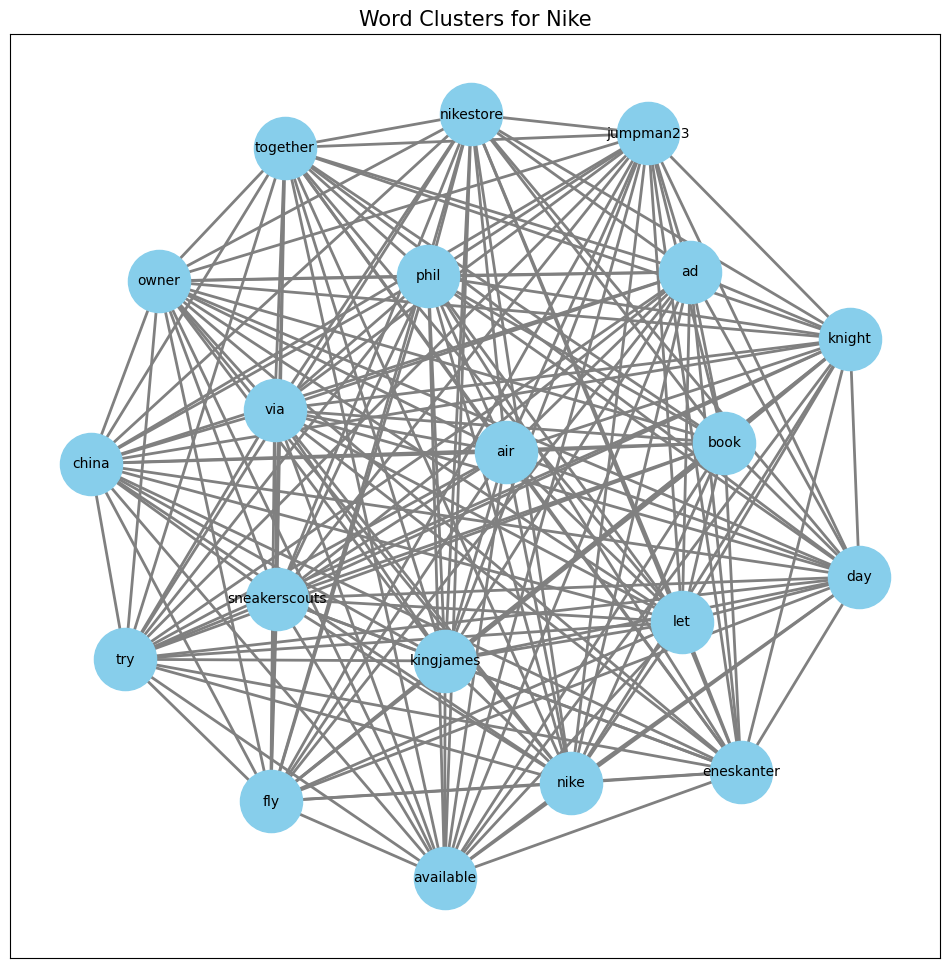

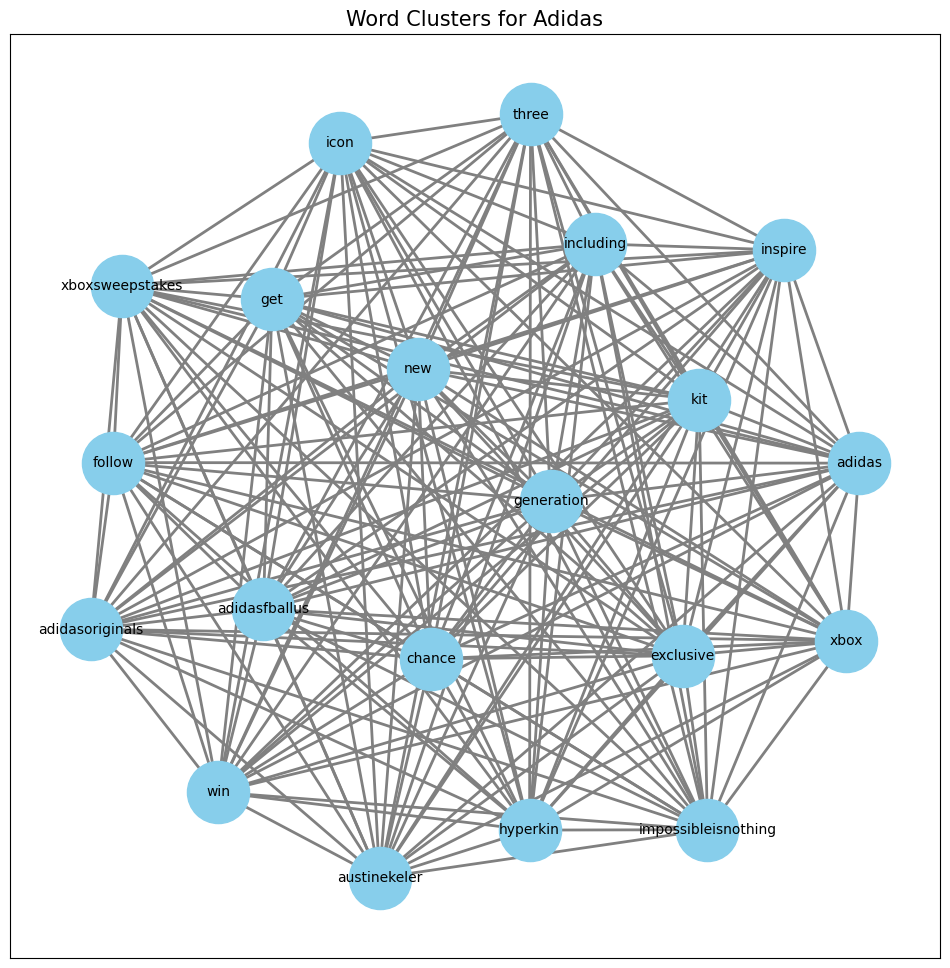

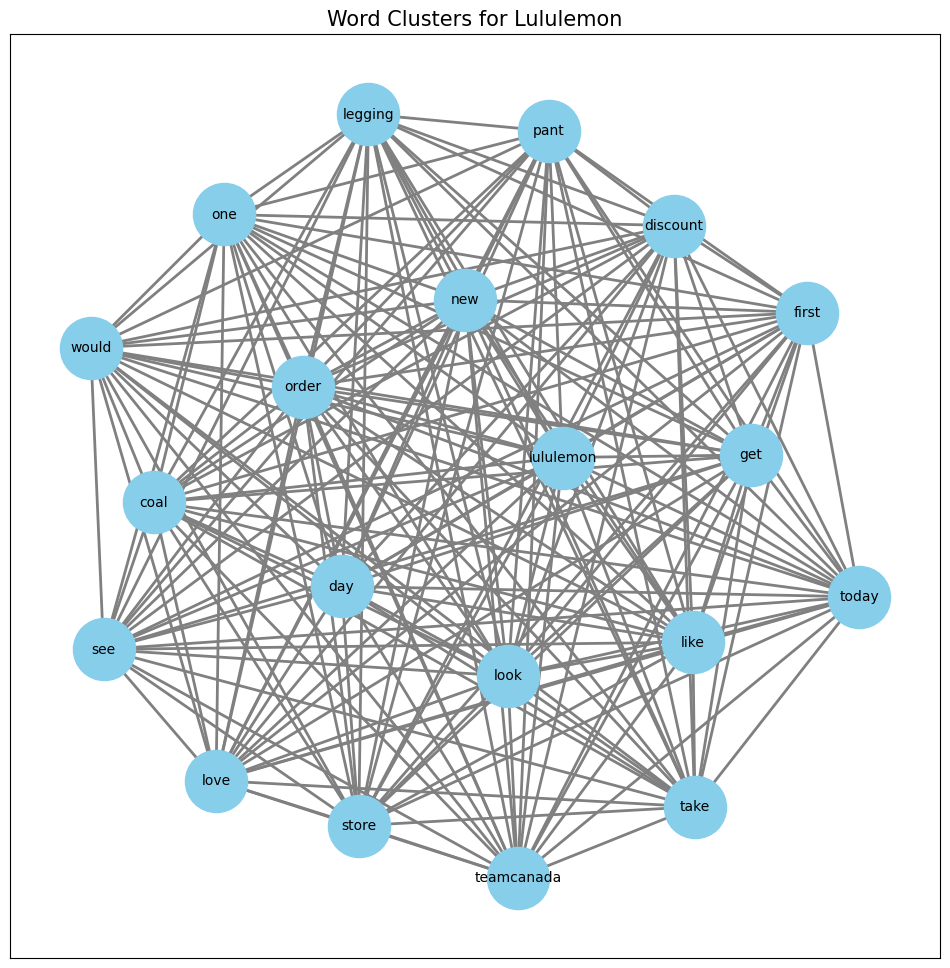

In [ ]:
import json
import gzip
import nltk
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import string

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Define constants
DATA_FILE = "drive/MyDrive/nikelululemonadidas_tweets.jsonl.gz"
BRANDS = ["nike", "adidas", "lululemon"]

# Tokenizers and processors
TWEET_TOKENIZER = nltk.TweetTokenizer().tokenize
LEMMATIZER = nltk.WordNetLemmatizer()

# Extend the NLTK stopwords list with "rt"
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add('rt')  # Add 'rt' to the stopwords set

# Preprocessing function to handle all tokenization, filtering, and cleaning
def preprocess_text(text, stopwords, min_word_length=3, tweet=True):
    tokens = TWEET_TOKENIZER(text.lower()) if tweet else nltk.word_tokenize(text.lower())

    # Remove stopwords, short words, unwanted tokens, links, and punctuation
    tokens = [t for t in tokens if len(t) >= min_word_length and t not in stopwords and t not in ["...", "'", '"', "_"]]
    tokens = [t for t in tokens if not (t.startswith("http://") or t.startswith("https://"))]  # Remove links
    tokens = [t.translate(str.maketrans('', '', string.punctuation)).strip() for t in tokens if t not in string.punctuation]

    # Lemmatize tokens
    return [LEMMATIZER.lemmatize(token) for token in tokens]

# Function to filter and categorize tweets by brand
def categorize_tweets_by_brand(data_file, brands):
    categorized_tweets = defaultdict(list)

    with gzip.open(data_file, 'rt', encoding='utf-8') as file:
        for line in file:
            tweet = json.loads(line)
            tweet_text = tweet.get("full_text", tweet.get("text", "")).lower()

            # Check for brand keywords in the tweet text
            for brand in brands:
                if brand in tweet_text:
                    categorized_tweets[brand].append(tweet_text)
                    break  # If a tweet matches one brand, we can stop checking

    return categorized_tweets

# Function to process and count word frequencies per brand
def process_tweets_by_brand(categorized_tweets, stopwords):
    processed_tweets = {}

    for brand, tweets in categorized_tweets.items():
        word_counts = Counter()

        for text in tweets:
            tokens = preprocess_text(text, stopwords)
            word_counts.update(tokens)

        processed_tweets[brand] = word_counts

    return processed_tweets

# Function to create word clusters (semantic network) based on co-occurrences
def build_word_clusters(processed_tweets, top_n=50):
    brand_word_clusters = {}

    for brand, word_counts in processed_tweets.items():
        graph = nx.Graph()

        # Get the top N terms to focus on the most frequent terms
        top_terms = [term for term, _ in word_counts.most_common(top_n)]

        for tokens in itertools.combinations(top_terms, 2):
            graph.add_edge(*tokens)

        brand_word_clusters[brand] = graph

    return brand_word_clusters

# Visualize the word clusters for each brand
def visualize_word_clusters(brand_word_clusters):
    for brand, graph in brand_word_clusters.items():
        plt.figure(figsize=(12, 12))
        plt.title(f"Word Clusters for {brand.capitalize()}", size=15)
        pos = nx.spring_layout(graph)
        nx.draw_networkx(graph, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=10, width=2, edge_color="gray")
        plt.show()

# Main flow
# 1. Categorize tweets by brand
categorized_tweets = categorize_tweets_by_brand(DATA_FILE, BRANDS)

# 2. Process the categorized tweets (tokenize, clean, and count word frequencies)
processed_tweets = process_tweets_by_brand(categorized_tweets, stopwords)

# 3. Build word clusters (semantic networks) for each brand
brand_word_clusters = build_word_clusters(processed_tweets, top_n=20)

# 4. Visualize the word clusters
visualize_word_clusters(brand_word_clusters)


# **Key Insights from the Clusters:**
## **Nike:**
- Cluster 0: Words like "nike", "sneakerscouts", "via", "available", "air" suggest that Nike's clusters focus heavily on product availability, sneaker releases, and brand promotions.
- Cluster 5: Includes "lebron", "james", "deal", indicating discussions about LeBron James and Nike's endorsements or collaborations.
- Cluster 16: Words like "adidas", "adidasoriginals", "nikesb", "puma" suggest there are cross-brand discussions comparing Nike with competitors.

## **Adidas:**
- Cluster 1: Words like "adidas", "brand", "help", "new" suggest themes around brand identity, new product launches, and customer support.
- Cluster 4: Mentions "beyonce", "ivypark" suggest Adidas' collaboration with Beyoncé and her Ivy Park line is a key conversation.
- Cluster 18: Words like "nfl", "reebok", "underarmour" suggest discussions around Adidas' involvement in sports (e.g., NFL) and comparisons to other sports brands.

## **Lululemon:**
- Cluster 1: Includes words like "teamcanada", "look", "best", indicating discussions about team affiliations and positive brand perception.
- Cluster 4: Mentions like "legging", "store", "customer" highlight conversations around Lululemon's products and customer service.
- Cluster 8: Words like "discount", "healthcare", "worker" i*ndicate that Lululemon is also being discussed in relation to healthcare workers and potentially discount programs or promotional offers.*
---


## **How We Can Use this Information:**
### **Brand Perception & Messaging:**
The central words in each cluster can help you understand how users talk about the brands on Twitter. Nike has a strong association with product launches, Adidas with collaborations (e.g., Beyoncé), and Lululemon with community and product quality (e.g., leggings, customer service).
You can use these insights to refine brand messaging. For example, if discussions around customer service are prominent for Lululemon, the company may want to emphasize customer experience in future campaigns.
### **Marketing & Product Focus:**
Nike has multiple clusters discussing specific athletes (e.g., LeBron James) and sneaker releases, which suggests Nike's marketing efforts around these themes are resonating. Nike could further leverage this by emphasizing collaborations in marketing campaigns.
Adidas has conversations about both Beyoncé's Ivy Park line and sports involvement. Adidas can reinforce these key brand pillars by focusing its campaigns on lifestyle and performance.
Lululemon sees mentions of discounts for healthcare workers, which suggests a strong community-oriented message. Lululemon could consider expanding its healthcare worker programs or highlighting them more prominently in marketing materials.
### **Competitive Positioning:**
In Nike's clusters, cross-brand comparisons with Adidas and Puma are prominent (Cluster 16). These comparisons show the competitive space where Nike operates. It indicates that users are actively comparing these brands, so Nike might want to emphasize its differentiators (e.g., technology, style) in this context.
### **Community Engagement:**
Lululemon shows a strong community and wellness focus in Cluster 16, with words like "community", "together", "body". This suggests that community and fitness are key drivers of conversation for the brand. Lululemon could further engage this community through fitness events or collaborations with wellness influencers.

---

### **Step 7:** Sentiment Segmentation

- Perform Sentiment Analysis:
Classify each tweet as positive, negative, or neutral using sentiment analysis tools like vaderSentiment.
Question: How does sentiment affect word clusters and mentions?

- Build separate mention graphs and word co-occurrence networks for positive and negative tweets.
Action:

- Write a function to classify tweets by sentiment and build separate graphs for positive and negative sentiment.

---

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify tweet sentiment
def classify_tweet_sentiment(tweet_text):
    sentiment_score = sia.polarity_scores(tweet_text)

    # Classify the tweet based on compound score
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment classification to each tweet
def add_sentiment_to_tweets(tweets):
    for tweet in tweets:
        text = tweet.get("text", "")
        sentiment = classify_tweet_sentiment(text)
        tweet["sentiment"] = sentiment

# Classify the sentiment of all tweets
add_sentiment_to_tweets(tweets_data)

# Separate tweets into positive, negative, and neutral
def split_tweets_by_sentiment(tweets):
    positive_tweets = []
    negative_tweets = []
    neutral_tweets = []

    for tweet in tweets:
        if tweet["sentiment"] == "positive":
            positive_tweets.append(tweet)
        elif tweet["sentiment"] == "negative":
            negative_tweets.append(tweet)
        else:
            neutral_tweets.append(tweet)

    return positive_tweets, negative_tweets, neutral_tweets

# Split tweets by sentiment
positive_tweets, negative_tweets, neutral_tweets = split_tweets_by_sentiment(tweets_data)

# Print the number of tweets in each category
print(f"Positive tweets: {len(positive_tweets)}")
print(f"Negative tweets: {len(negative_tweets)}")
print(f"Neutral tweets: {len(neutral_tweets)}")

# Preprocess tweet text for co-occurrence (this function should be defined earlier)
def preprocess_tweet_text_for_cooccurrence(tweets, stopwords=nltk.corpus.stopwords.words("english")):
    tweet_words = []
    for tweet in tweets:
        text = tweet.get("text", "")
        tokens = tokenize(text, lowercase=True, tweet=True)  # Ensure the tokenize function is defined
        tokens = remove_stopwords(tokens, stopwords=stopwords)
        tokens = remove_links(tokens)
        tokens = remove_punctuation(tokens, strip_mentions=True, strip_hashtags=True)
        tokens = lemmatize(tokens)
        tweet_words.append(tokens)
    return tweet_words

# Build co-occurrence graphs for positive and negative tweets
positive_words = preprocess_tweet_text_for_cooccurrence(positive_tweets)
negative_words = preprocess_tweet_text_for_cooccurrence(negative_tweets)

# Build co-occurrence graph from tokenized tweet words (this function should also be defined earlier)
def build_cooccurrence_graph(tweet_words):
    cooccurrence_graph = nx.Graph()
    for tokens in tweet_words:
        for word_pair in itertools.combinations(tokens, 2):
            word1, word2 = sorted(word_pair)
            if cooccurrence_graph.has_edge(word1, word2):
                cooccurrence_graph[word1][word2]['weight'] += 1
            else:
                cooccurrence_graph.add_edge(word1, word2, weight=1)
    return cooccurrence_graph

# Build the co-occurrence graphs for positive and negative sentiment tweets
positive_cooccurrence_graph = build_cooccurrence_graph(positive_words)
negative_cooccurrence_graph = build_cooccurrence_graph(negative_words)

# Print the graph statistics
print(f"Positive Co-occurrence Graph: {positive_cooccurrence_graph.number_of_nodes()} nodes, {positive_cooccurrence_graph.number_of_edges()} edges")
print(f"Negative Co-occurrence Graph: {negative_cooccurrence_graph.number_of_nodes()} nodes, {negative_cooccurrence_graph.number_of_edges()} edges")

# Run community detection for positive and negative co-occurrence graphs
positive_word_clusters = detect_communities(positive_cooccurrence_graph)  # Ensure this function is defined
negative_word_clusters = detect_communities(negative_cooccurrence_graph)  # Ensure this function is defined

# Limit tokens per cluster for each sentiment (this function limits tokens in clusters)
def limit_tokens_per_cluster(clusters, cooccurrence_graph, top_n=10):
    limited_clusters = {}
    for cluster_id, words in clusters.items():
        # Sort words by centrality (or another measure) and limit to top_n
        word_centrality = nx.degree_centrality(cooccurrence_graph)
        sorted_words = sorted(words, key=lambda word: word_centrality.get(word, 0), reverse=True)
        limited_clusters[cluster_id] = sorted_words[:top_n]
    return limited_clusters

# Limit tokens per cluster
limited_positive_clusters = limit_tokens_per_cluster(positive_word_clusters, positive_cooccurrence_graph, top_n=10)
limited_negative_clusters = limit_tokens_per_cluster(negative_word_clusters, negative_cooccurrence_graph, top_n=10)

# Display positive clusters
print("\nWord clusters for Positive Sentiment Tweets:")
for cluster_id, words in limited_positive_clusters.items():
    print(f"Cluster {cluster_id}: {words}")

# Display negative clusters
print("\nWord clusters for Negative Sentiment Tweets:")
for cluster_id, words in limited_negative_clusters.items():
    print(f"Cluster {cluster_id}: {words}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Positive tweets: 63905
Negative tweets: 29804
Neutral tweets: 81369
Positive Co-occurrence Graph: 49816 nodes, 2226028 edges
Negative Co-occurrence Graph: 28084 nodes, 1234352 edges

Word clusters for Positive Sentiment Tweets:
Cluster 0: ['nike', '’', 'like', 'get', 'love', 'one', 'shoe', 'good', 'would', 'jumpman23']
Cluster 28: ['adidas', '…', 'rt', 'win', 'chance', 'xbox', 'saw', 'exclusive', 'tech', 'including']
Cluster 2: ['️', '3', 'happy', 'gear', 'number', 'send', 'kind', 'side', 'thinking', '👍']
Cluster 17: ['\u2069', '\u2066', 'v', 'continue', '🏀', 'honor', 'award', 'picked', 'legacy', 'anniversary']
Cluster 4: ['partnership', 'puma', 'stock', 'grow', '40', 'helped', 'bapeofficial', 'faster', 'championusa', 'larger']
Cluster 32: ["i'm", 'every', 'support', 'business', 'amazon', '❤', 'show', "that's", 'nfl', 'end']
Cluster 18: ['year', '“', '”', '1', 'team', 'today', 'nba', 'first', 'jordan', 'mean']
Cluster 7: ['air', 'via', 'white', '100', 'available', 'ad', 'grey', 'n', 'm

## **Conclusion**